# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale

 
$\sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.






In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [4]:
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321761 entries, 0 to 1321760
Data columns (total 24 columns):
cfStrutturaProponente                1321761 non-null int64
cig                                  1321754 non-null object
denominazioneStrutturaProponente     1321602 non-null object
oggetto                              1321651 non-null object
sceltaContraente                     1321758 non-null object
importoAggiudicazione                1321760 non-null float64
importoSommeLiquidate                1321760 non-null float64
dataInizio                           1321761 non-null object
dataUltimazione                      1148870 non-null object
jsonPartecipanti                     1321761 non-null object
jsonAggiudicatari                    1321761 non-null object
totalePartecipanti                   1321761 non-null int64
totaleAggiudicatari                  1321761 non-null int64
totaleRaggruppamentopartecipanti     1321761 non-null int64
totaleRaggruppamentoAggiudicatari  

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [5]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

In [6]:
def aggregateByOggetto(col_groupBy, col_toAgg, df):
    """
    col_groupBy: è la colonna per la quale effettuare l'aggragazione
    col_toAgg: è la colonna contenente le informazioni non strutturate, i.e. campo "oggetto"
    df: input dataframe
    """
    df_noEmpty = df.dropna(subset=[col_toAgg], axis=0)
    new_series = df_noEmpty.groupby(col_groupBy)[col_toAgg].apply(lambda x: ' '.join(x)) 
    return pd.DataFrame(new_series)

In [7]:
final_df = pd.DataFrame(columns=['codiceFiscaleStruttura', 'oggetto', "tipoStruttura"])
final_df.head()

,codiceFiscaleStruttura,oggetto,tipoStruttura


In [8]:
for col, type_col in columns_to_aggregate:
    t0 = time()
    aggregate_df = aggregateByOggetto(col, "oggetto", df) 
    total = time() - t0

    aggregate_df['tipoStruttura'] = [type_col] * aggregate_df.shape[0]
    aggregate_df.rename(columns={col: 'codiceFiscaleStruttura'})

    final_df = final_df.append(aggregate_df)
    
    print("Aggregation of attribute %s done in %0.3f sec" % (col, total))
    print(aggregate_df["oggetto"].head(3))


Aggregation of attribute cfStrutturaProponente done in 0.749 sec
cfStrutturaProponente
8010803     MANUTENZIONE RECINZIONE E MESSA IN SICUREZZA C...
31730948    MANUTENZIONE AUTOMEZZO RIFIUTI RIPARAZIONE MEZ...
32020943    CORSO ANTINCENDIO NOMINA MEDICO E VISITE MEDIC...
Name: oggetto, dtype: object
Aggregation of attribute cfPrimoaggiudicatario done in 9.753 sec
cfPrimoaggiudicatario
         SOSTITUZIONE CALDAIA CENTRALE TERMICA AMPLIAME...
         servizio 22202 organizzazione incontri daffari...
         SENSORI NGIMU with Housing and Battery  NGIMU ...
Name: oggetto, dtype: object


In [9]:
t0 = time()
file_name = "data/oggetti_aggregati.pickle"
final_df.to_pickle(file_name)
total = time() - t0

print("Dataset stored in %0.3f sec" % total)

Dataset stored in 0.438 sec


In [10]:
#rilascia la memoria associata al DataFrame
del [[df, final_df]]

## Implementazione Soluzione 1

In [11]:
from nltk.stem.snowball import ItalianStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

class StemmedCountVectorizer(TfidfVectorizer):
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        
def get_TFIDFmatrix_vect(data, do_stemming):
    """
    data: input textual collection
    do_stemming: boolean. If True execute stemming, otherwise analyze only tokenized words (words are composed at least 2 chars and do not contains numbers)
    """
    t0 = time()
    
    if do_stemming:
        
        italian_stemmer = ItalianStemmer()
        tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', max_features=1000, analyzer="word", stop_words=stopwords.words('italian'))

    else:
        tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', stop_words=stopwords.words('italian'), max_features=1000) #CountVectorizer supports counts of N-grams of words or consecutive characters.
    
    matrix = tf.fit_transform(data)  
    return matrix, tf

def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words[0:N]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)

    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'  
    fig.tight_layout() 
    plt.savefig(file_name, pad = 0) #png

    plt.clf
    return file_name

In [12]:
file_name = "data/oggetti_aggregati_labels.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

Dataset loaded in 0.231 sec


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254124 entries,   to 99003240787
Data columns (total 4 columns):
codiceFiscaleStruttura    0 non-null object
oggetto                   254124 non-null object
tipoStruttura             254124 non-null object
dbscan                    254124 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.7+ MB


In [14]:
t0 = time()

matrix, tf = get_TFIDFmatrix_vect(df.oggetto, False)
total = time() - t0
print("TFIDF matrix done in %0.3f sec" % total)

TFIDF matrix done in 11.806 sec


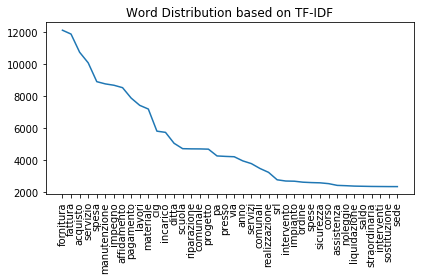

In [15]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

### Dimension reduction

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import DBSCAN
t0 = time()
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
total = time() - t0
print("Preprocessing done in done in %0.3f sec" % total)

np.save("data/fasttext/matrix_embedding.txt", preprocessing)

Preprocessing done in done in 13.209 sec


### Soluzione 2 

In [ ]:
from gensim.models import KeyedVectors
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

In [ ]:
#for i in range(0,df.shape[0]):
top_words = 300
n_rows = df.shape[0]
vocabulary = tf.vocabulary_
terms, frequency = zip(*sorted_scores)

embedded_matrix = np.empty((n_rows,300), float)
t0 = time()

for i in range(0, n_rows):
    
    embedding_d = [0] * 300
    counter_d = 0
    
    for term in terms[:top_words]:
        if term in jp_model.vocab:

            index_t = vocabulary[term]
            tfidf = matrix[i,index_t]
            if(tfidf != 0):
                embedding_d +=  jp_model.get_vector(term)
                counter_d += 1
    
    if counter_d > 0:
        embedding_d = embedding_d / counter_d
    
    embedded_matrix[i] = embedding_d #np.append(embedded_matrix, embedding_d, 0)
total = time() - t0 
print("Embedding done in %0.3f sec" % total)

In [ ]:
np.save("data/fasttext/matrix_embedding.txt", embedded_matrix)

In [ ]:
## libera memoria
#una volta lanciato questo comando verranno perse le variabili
%reset

## Costruzione degli edge

In [ ]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [ ]:
file_name = "data/fasttext/matrix_embedding.txt"
matrix = np.load(file_name)

In [ ]:
# Calculate cosine similarity

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

dist_out = 1-pairwise_distances(matrix, metric="cosine")
dist_out